# 决策树集成
**集成（ensemble）**是合并多个机器学习模型来构建更强大模型的方法。在机器学习文献中有许多模型都属于这一类，但已注明有两种集成模型对大量分类和回归的数据集都是有效的，二者都已决策树为基础，分别是**随机森林（random forest）**和**梯度提升决策树（gradient boosted decision tree）**。

In [1]:
import sys
print("Python version:{}".format(sys.version))

import pandas as pd
print("pandas version:{}".format(pd.__version__))

import matplotlib
print("matplotlib version:{}".format(matplotlib.__version__))
import matplotlib.pyplot as plt

import numpy as np
print("Numpy version:{}".format(np.__version__))

import scipy as sp
print("Scipy version:{}".format(sp.__version__))

import IPython
print("IPython version:{}".format(IPython.__version__))

import sklearn
print("scikit-learn version:{}".format(sklearn.__version__))

import mglearn
import graphviz

Python version:3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
pandas version:0.23.4
matplotlib version:3.0.2
Numpy version:1.15.4
Scipy version:1.1.0
IPython version:7.2.0
scikit-learn version:0.20.1


# 随机森林
随机森林是为了解决决策树经常过拟合的一种方法。随机森林本质上是许多决策树的集合，其中每棵树和其他树略有不同。随机森林背后的思想是，每棵树的预测可能都相对较好，但可能对部分数据过拟合。如果构造很多树，并且每棵树的预测都很好，但都以不同的方式过拟合，那么我们可以对这些树的结果取平均值来降低过拟合。既能减少过拟合又能保持树的预测能力，这可以在数学上严格证明。  
为了实现这一策略，我们需要构造许多决策树，每棵树都应该对目标值做出可以接受的预测，还应该与其他树不同。随机森林的名字来自于将随机性添加到树的构造过程中，以确保每棵树都各不相同。随机森林中树的随机化方法有两种：一种是通过选择用于构造树的数据点，另一种是通过选择每次划分测试的特征。

## 构造随机森林
想要构造一个随机森林模型，你需要确定用于构造的树的个数（RandomForestRegressor或RandomForestClassifier的n_estimators参数）。比如我们需要构造10棵树。这些树在构造时彼此完全独立，算法对每棵树进行不同的随机选择，以确保树和树之间是有区别的。想要构造一棵树，首先要对数据进行自助采样（boostrap sample）。也就是说，从n_samples个数据点钟有放回地（即同一样本可以被多次抽取）重复随机抽取一个样本，共抽取n_samples次。这样会创建一个与原数据集大小相同的数据集，但有些数据点会缺失（大约三分之一），有些会重复。  
接下来，基于这个新创建的数据集来构造决策树。但是这里要对数据集的特征选取稍作修改：在每个结点处，算法随机选择特征的一个子集，并对其中一个特征寻找最佳测试，而不是对每个结点都寻找最佳测试。选择的特征个数由max_features参数来控制。每个结点中特征子集的选择是相互独立的，这样树的每个结点可以使用特征的不同子集来做出决策。  
由于使用了自助采样，随机森林中构造每棵决策树的数据集都略有不同的。由于每个结点的特征选择，每棵树中的每次划分都是基于特征的不同子集。这两种方法共同保证随机森林总所有树都不相同。  
在这个过程中的一个关键参数是max_features。如果我们设置max_features等于n_features,那么每次划分都要考虑数据集的所有特征，在特征选择的过程中没有添加随机性（不过自助采样依然存在随机性）。如果设置max_featues等于1，那么在划分时将无法选择对哪个特征进行测试，只能对随机选择的某个特征搜索不同的阈值。因此，如果max_features较大，那么随机森林中的树将会十分相似，利用最独特的特征可以轻松拟合数据。如果max_features较小，那么随机森林中的树将会差异很大，为了很好地拟合数据，每棵树的深度都要很大。  
想要利用随机森林较小预测，算法首先对森林中的每棵树进行预测。对于回归问题，我们可以对这些结果取平均值作为最终预测。对于分类问题，则用到了“软投票”（soft voting）策略。也就是说，每个算法做出“软”预测，给出每个可能的输出标签的概率。对所有树的预测概率取平均值，然后将概率最大的类别作为预测结果。


### 分析随机森林

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X,y=make_moons(n_samples=100,noise=0.25,random_state=3)
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=42)
forest=RandomForestClassifier(n_estimators=5,random_state=2)
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

作为随机森林的一部分，树被保存在estimator_属性中。我们将每棵树学到的决策边界可视化，也将它们的总预测（即整个森林做出的预测）可视化：

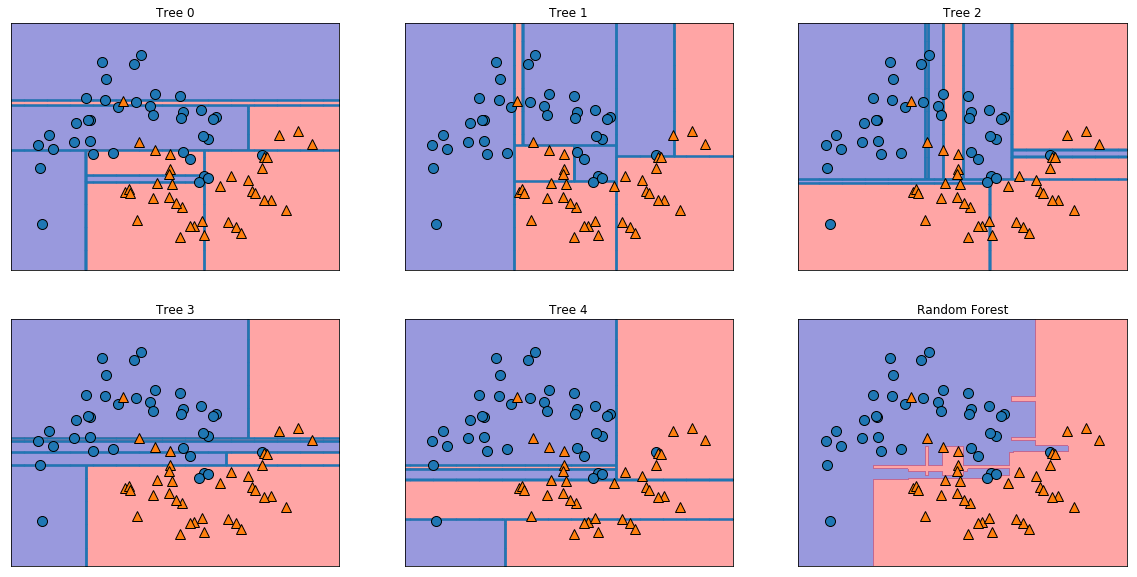

In [3]:
fig,axes=plt.subplots(2,3,figsize=(20,10))
for i,(ax,tree) in enumerate(zip(axes.ravel(),forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X_train,y_train,tree,ax=ax)
mglearn.plots.plot_2d_separator(forest,X_train,fill=True,ax=axes[-1,-1],alpha=.4)
axes[-1,-1].set_title("Random Forest")
mglearn.discrete_scatter(X_train[:,0],X_train[:,1],y_train)

从上述一组图中可以看到，这5棵树学到的决策边界大不相同。每棵树都犯了一些错误，因为这里画出的一些训练点实际上并没有包含在这些树的训练集中,原因在于自助采样。  
随机森林比单独每一棵树的过拟合都要小，给出的决策边界也更符合直觉。在任何实际应用中，我们会用到更多棵树（通常是几百或上千），从而得到更平滑的边界。

再举一个例子，我们将包含100棵树的随机森林应用在乳腺癌数据集上：

In [4]:
from sklearn.datasets import load_breast_cancer
cancer=load_breast_cancer()

X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target,random_state=0)
forest=RandomForestClassifier(n_estimators=100,random_state=0)
forest.fit(X_train,y_train)

print("Accuracy on training set:{:.3f}".format(forest.score(X_train,y_train)))
print("Accuracy on test set:{:.3f}".format(forest.score(X_test,y_test)))

Accuracy on training set:1.000
Accuracy on test set:0.972


在没有调节任何参数的情况下，随机森林的精度为97%，比线性模型或单棵决策树都要好。我们可以调节max_features参数，或者像单棵决策树那样进行预剪枝。但是，随机森林的默认参数就已经可以给出很好的结果。  
与决策树类似，随机森林也可以给出特征重要性，计算方法是将森林中所有树的特征重要性求和并取平均。一般来说，随机森林给出的特征重要性要比单棵树给出的更为可靠，如下：

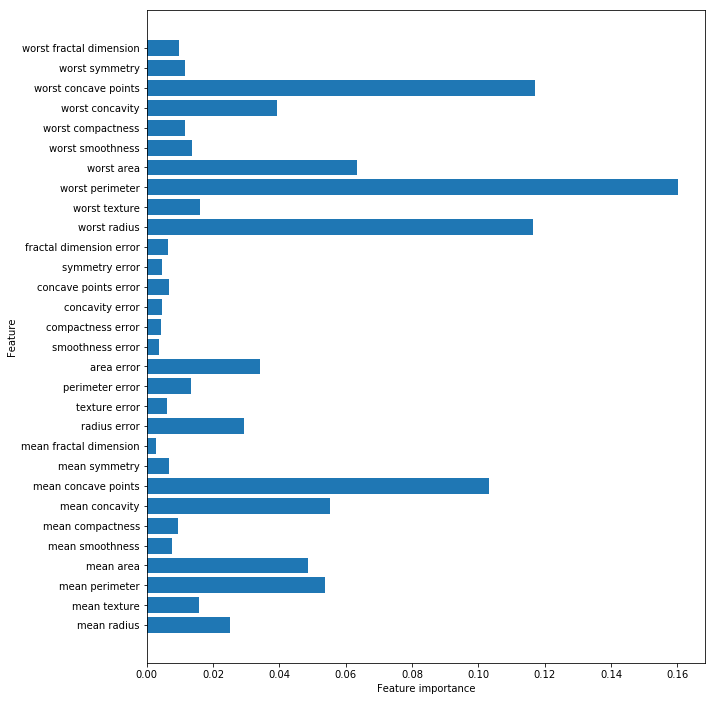

In [5]:
def plot_feature_importances_cancer(model):
    n_features=cancer.data.shape[1]
    plt.subplots(figsize=(10,12))
    plt.barh(range(n_features),model.feature_importances_,align='center')
    plt.yticks(np.arange(n_features),cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
plot_feature_importances_cancer(forest)

从上图我们可以看到，与单棵树相比，随机森林中有更多特征的重要性不为零，与单棵决策树类似，随机森林也给了“worst radius”（最大半径）特征很大的重要性，但从主体来看，它实际上却选择“worst perimeter”（最大周长）作为信息量最大的特征。由于构造随机森林过程中的随机性，算法需要考虑多种可能的解释，结果就是随机森林比单棵树更能从总体把握数据的特征。

## 优点、缺点和参数
用于回归和分类的随机森林是目前应用最广泛的机器学习方法之一。这种方法非常强大，通常不需要反复调节参数就可以给出很好的结果，也不需要对数据进行缩放。  
从本质上看，随机森林拥有决策树的所有优点，同时弥补了决策树的一些缺陷。仍然使用决策树的一个原因是需要决策过程的紧凑表示。基本上不可能对几十棵甚至上百棵树做出详细解释，随机森林中树的深度往往比决策树还要大（因为用到了特征子集）。
虽然在大型数据集上构建随机森林可能比较费时间，但在一台计算机的多个CPU内核上并行计算也很容易。
对于维度非常高的稀疏数据（比如文本数据），随机森林的表现往往不是很好。对于这种数据，使用线性模型可能更合适。即使是非常大的数据集，随机森林的表现也很好，训练过程很容易并行在功能强大的计算机的多个CPU内核上。不过随机森林需要更大的内存，训练和预测的速度也比线性模型要慢。对一个应用来说，如果时间和内存很重要的话，那么换用线性模型可能更为明智。  
需要调节的参数有n_estimators和max_features,可能还包括预剪枝选项（如max_depth）。n_estimators总是越大越好。对更多的树取平均可以降低过拟合，从而得到鲁棒性更好地集成。不过收益是递减的，而且而且树越多需要的内存也越多，训练时间也越长。常用的经验法则是“在你的时间/内存允许的情况下尽量多”。  
前面说过，max_features决定每棵树的随机性大小，较小的max_features可以降低过拟合。一般来说，好的经验就是使用模型认知：对于分类，默认值是max_features=sqrt(n_features)；对于回归，默认值就是max_features=n_features。增大max_features或者max_leaf_nodes有时也可以提高效能。它还可以大大降低用于训练和预测的时间和空间要求。   

## 梯度提升回归树（梯度提升机）
梯度提升回归树是另一种集成方法，通过合并多个决策树来构建一个更为强大的模型，通过合并多个决策树来构建一个更为强大的模型。虽然名字中含有“回归”，但这个模型可以用于回归也可以用于分类。与随机森林方法不同，梯度提升采用连续的方法构造树，每棵树都试图纠正前一棵树的错误。默认情况下，梯度提升回归树中没有随机化，而是用到了强预剪枝。梯度提升树通常使用深度很小（1到5之间）的树，主要模型占用的内存更少，预测速度也更快。  
梯度提升背后的主要思想是合并许多简单的模型（在这个语境中叫作弱学习器），比如深度较小的树。每棵树只能对部分数据做出好的预测，因此，添加的树越来越多，可以不断迭代提高效能。  
梯度提升树经常是机器学习竞赛的优胜者，并且广泛应用于业界。与随机森林相比，它通常对参数设置更为敏感，但如果参数设置正确的话，模型精度更高。  
除了预剪枝与集成中树的数量之外，梯度提升的另一个重要参数是learning_rate（学习率），用于控制每棵树纠正前一棵树的错误的强度。较高的学习率意味着每棵树都可以做出较强的修正，这样模型更为复杂。通过增大n_estimators来向集成中添加更多树，也可以增加模型复杂度，因为模型有更多机会纠正训练集上的错误。  
下面是以在乳腺癌数据集上应用GradientBoostingClassifierd的示例。默认使用100棵树，最大深度是3，学习率为0.1：


In [8]:
from sklearn.ensemble import GradientBoostingClassifier

X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target,random_state=0)

gbrt=GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train,y_train)

print("Accuracy on training set:{:.3f}".format(gbrt.score(X_train,y_train)))
print("Accuracy on test set:{:.3f}".format(gbrt.score(X_test,y_test)))

Accuracy on training set:1.000
Accuracy on test set:0.958


由于训练集精度达到100%，所以可能存在过拟合。为了降低过拟合，我们可以限制最大深度来加强预剪枝，也可以降低学习率：

In [11]:
gbrt=GradientBoostingClassifier(random_state=0,max_depth=1)
gbrt.fit(X_train,y_train)

print("Accuracy on training set:{:.3f}".format(gbrt.score(X_train,y_train)))
print("Accuracy on test set:{:.3f}".format(gbrt.score(X_test,y_test)))

Accuracy on training set:0.991
Accuracy on test set:0.972


In [12]:
gbrt=GradientBoostingClassifier(random_state=0,learning_rate=0.01)
gbrt.fit(X_train,y_train)

print("Accuracy on training set:{:.3f}".format(gbrt.score(X_train,y_train)))
print("Accuracy on test set:{:.3f}".format(gbrt.score(X_test,y_test)))

Accuracy on training set:0.988
Accuracy on test set:0.965


降低模型复杂度的两种方法都降低了训练集精度，这和预期相同。在这个例子中，减小树的最大深度显著提升了模型性能，而降低学习率金稍稍提高了泛化性能。
对于其他基于决策树的模型，我们也可以将特征重要性可视化，以便更好地理解模型。由于我们用到了100棵树，所以即使所有树的深度都是1，查看所有树也是不现实的：

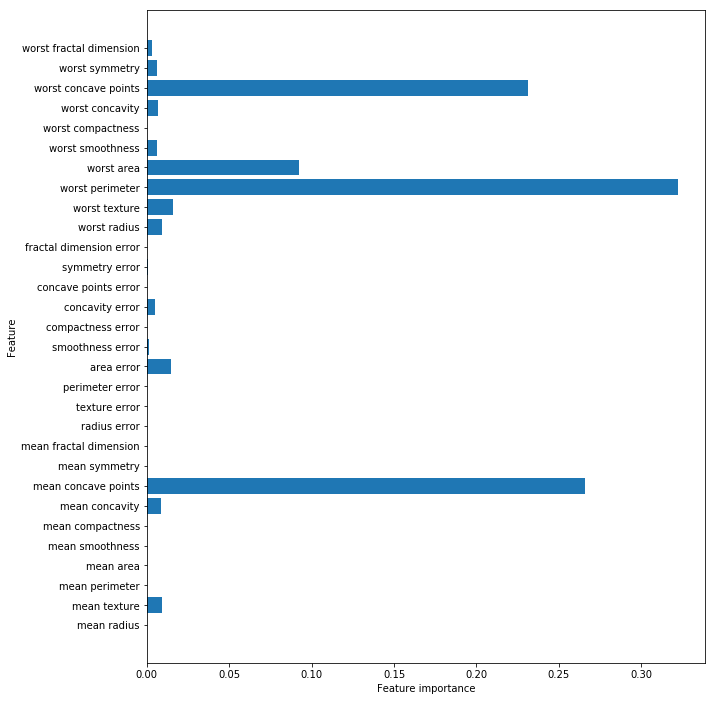

In [14]:
gbrt=GradientBoostingClassifier(random_state=0,max_depth=1)
gbrt.fit(X_train,y_train)

plot_feature_importances_cancer(gbrt)

从上图可以看到，梯度提升树的特征重要性与随机森林的特征重要性有些类似，不过梯度提升完全忽略了某些特征。  
由于梯度提升和随机森林两种方法在类似的数据上表现得都很好，因此一种常用的方法就是先尝试随机森林，它的鲁棒性很好。如果随机森林效果很好，但预测时间太长，或者机器学习模型精度小数点后两位的提高也很重要，那么切换成梯度提升通常会有用。  
如果你想要将梯度提升有用在大规模问题上，可以研究一下xgboost包及其Python接口，这个库在许多数据集上的速度都比scikit-learn对梯度提升的实现要快（有时调参也更简单）。

## 优点、缺点和参数
梯度提升树是监督学习中最强大也最常用的模型之一。其主要缺点是需要仔细调参，而且训练时间可能会比较长。与其他基于树的模型类似，这一算法不需要对数据进行缩放可以表现得很好，而且也适用于二元特征与连续特征同时存在的数据集。与其他基于树的模型相同，它也通常不适用于高维稀疏数据。 
梯度提升树模型的主要参数包括树的数量n_estimators和学习率learning_rate，后者用于控制每棵树对前一棵树的错误的纠正强度。这两个参数高度相关，因为learning_rate越低，就需要更多的树来构建具有相似复杂度的模型。随机森林的n_estimators值总是越大越好，但梯度提升不同，增大n_estimators会导致模型更加复杂，进而可能导致过拟合。通常的做法是根据时间和内存的预算选择合适的n_estimators，然后对不同的learning_rate进行遍历。  
另一个重要参数是max_depth（或者max_leaf_nodes）,用于降低每棵树的复杂度。梯度提升模型的max_depth通常都设置得狠下，一般不超过5。